In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from time import sleep
import socket,time,requests
from bs4 import BeautifulSoup
import tkinter as tk
from datetime import date




url="https://uzmanpara.milliyet.com.tr/canli-borsa/bist-TUM-hisseleri/"
r=requests.get(url)
soup=BeautifulSoup(r.content,"html.parser")

bs=BeautifulSoup(r.content, "lxml")
data=soup.find("div",{"class":"box box10 last"})



In [6]:
data=soup.find("tr",{"id":"h_tr_id_AKBNK"})


In [8]:
data=soup.find("td",{"id":"h_td_fiyat_id_AKBNK"})
text=data.text

In [9]:
text=text.replace(',', '.')
text=float(text)
text

18.99

In [2]:
sok=pd.read_csv("/Users/Bora/Documents/GitHub/Borsa-Hisse-Analizi/akbnk.csv")
sok.index=pd.to_datetime(sok["Date"])


In [3]:
del sok["Date"]

In [4]:
sok=pd.DataFrame(sok)

In [5]:
sok

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-01-04,6.07,5.98,6.12,5.96,113.05M,2.19%
2021-01-05,6.02,6.05,6.18,5.97,156.98M,-0.82%
2021-01-06,6.30,6.14,6.30,6.12,174.67M,4.65%
2021-01-07,6.46,6.40,6.51,6.36,153.19M,2.54%
2021-01-08,6.43,6.52,6.54,6.40,116.69M,-0.46%
...,...,...,...,...,...,...
2023-06-13,18.03,18.08,18.45,17.74,192.89M,-0.28%
2023-06-14,18.37,18.10,18.92,17.97,277.30M,1.89%
2023-06-15,19.23,18.64,19.23,18.51,245.30M,4.68%


In [10]:
close=pd.DataFrame(sok["Price"])

close


,Price
Date,
2021-01-04,6.07
2021-01-05,6.02
2021-01-06,6.30
2021-01-07,6.46
2021-01-08,6.43
...,...
2023-06-13,18.03
2023-06-14,18.37
2023-06-15,19.23


In [10]:
dict={'Date':date.today(),'Price':text}
df=pd.DataFrame.from_dict(dict,orient="index")
df=df.T
df.reset_index()
df

,Date,Price
0,2023-06-19,32.3


In [11]:
df.set_index=df["Date"]
df

,Date,Price
0,2023-06-19,32.3


In [12]:
df.index=df["Date"]

In [13]:
del df["Date"]

In [14]:
df.index=pd.to_datetime(df.index)
df

,Price
Date,
2023-06-19,32.3


In [16]:
close=pd.concat([close,df])
close

,Price
Date,
2021-01-04,12.89
2021-01-05,13.05
2021-01-06,12.88
2021-01-07,12.95
2021-01-08,13.84
...,...
2023-06-14,30.64
2023-06-15,31.9
2023-06-16,32.3


In [90]:
rolling_app5=close.rolling(window=5).mean()
rolling_app14=close.rolling(window=20).mean()
rolling_app21=close.rolling(window=50).mean()



In [91]:
MAs=pd.concat([close,rolling_app5,rolling_app14,rolling_app21],axis=1)
MAs.columns=["Close","short","mid","long"]


In [92]:
MAs.dropna(axis=0,inplace=True)
MAs

,Close,short,mid,long
Date,,,,
2021-03-12,5.25,5.256,5.3695,5.6796
2021-03-15,5.18,5.244,5.3415,5.6618
2021-03-16,5.22,5.238,5.3235,5.6458
2021-03-17,5.13,5.202,5.3055,5.6224
2021-03-18,5.23,5.202,5.2965,5.5978
...,...,...,...,...
2023-06-13,18.03,18.322,16.3350,16.8238
2023-06-14,18.37,18.318,16.4650,16.8524
2023-06-15,19.23,18.434,16.6475,16.8966


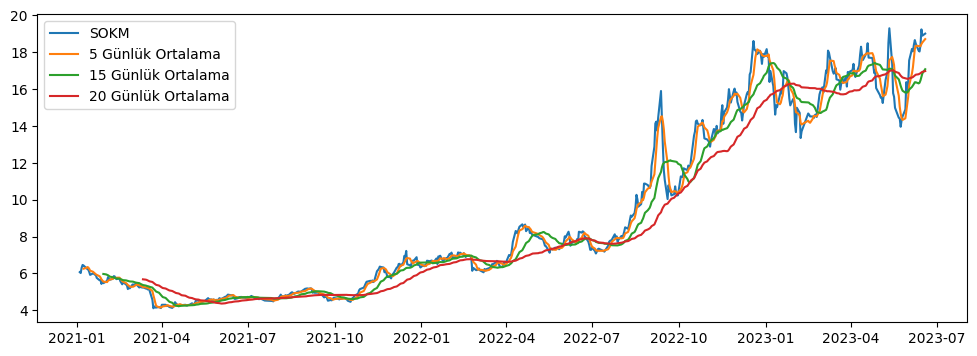

In [93]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(close.index,close,label='SOKM')
ax.plot(rolling_app5.index,rolling_app5,label='5 Günlük Ortalama')
ax.plot(rolling_app14.index,rolling_app14,label='15 Günlük Ortalama')
ax.plot(rolling_app21.index,rolling_app21,label='20 Günlük Ortalama')
ax.legend(loc='upper left')


In [94]:
def buy_sell(data,perc=25):
    buy_sell=[]
    buy_signal=[]
    sell_signal=[]
    flag=42

    sm=np.abs(np.percentile(np.array(data["short"]-data["mid"]),perc))
    sl=np.abs(np.percentile(np.array(data["short"]-data["long"]),perc))

    for i in range(0,len(data)):
        if (data["short"][i]>data["mid"][i]+sm) & (data["short"][i]>data["long"][i]+sl):
            buy_signal.append(np.nan)
            if flag !=1:
                sell_signal.append(data["Close"][i])
                buy_sell.append(data["Close"][i])
                flag=1
            else:
                sell_signal.append(np.nan)
        elif (data["short"][i]<data["mid"][i]-sm)&(data["short"][i]<data["long"][i]-sl):
            sell_signal.append(np.nan)
            if flag!=0:
                buy_signal.append(data["Close"][i])
                buy_sell.append(-data["Close"][i])
                flag=0
            else:
                buy_signal.append(np.nan)
        else:
            buy_sell.append(np.nan)
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)

    operations=np.array(buy_sell)
    operations=operations[~np.isnan(operations)]

    neg=0
    pos=0

    for i in range(len(operations)):
        if operations[i]<0:
            neg=i
            break
    for i in range(1,len(operations)):
        if operations[-i]>0:
            pos=i-1
            break
    operations=operations[neg:-pos]
    PL=np.sum(operations)

    return (buy_signal,sell_signal,PL)


In [95]:
m=buy_sell(MAs)
MAs["Al"]=m[0]
MAs["Sat"]=m[1]

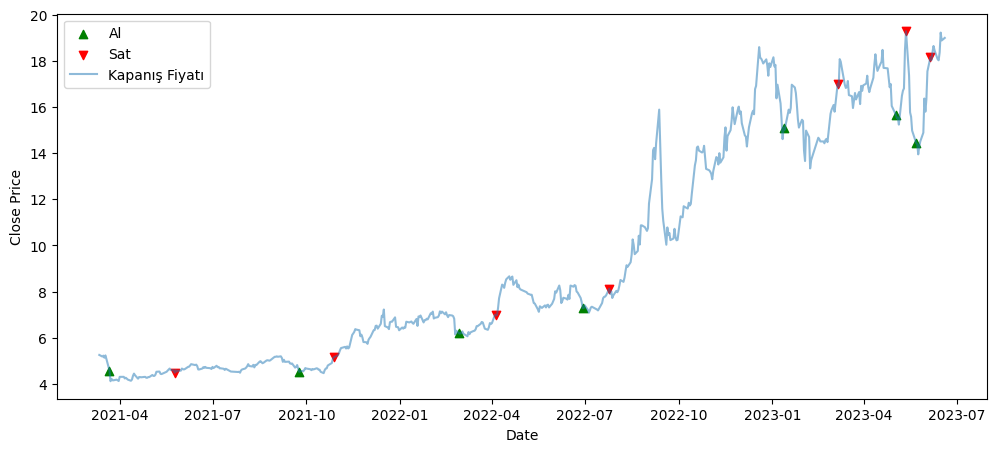

In [96]:
plt.figure(figsize=(12,5))
plt.scatter(MAs.index,MAs["Al"],color="green",label='Al',marker='^',alpha=1)
plt.scatter(MAs.index,MAs["Sat"],color="red",label='Sat',marker='v',alpha=1)
plt.plot(MAs["Close"],label='Kapanış Fiyatı',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()

In [97]:
al=MAs["Al"]
al=al.dropna(axis=0)
al

Date
2021-03-22     4.57
2021-09-24     4.52
2022-02-28     6.18
2022-06-29     7.28
2023-01-12    15.11
2023-05-02    15.67
2023-05-22    14.44
Name: Al, dtype: float64

In [98]:
sat=MAs["Sat"]
sat=sat.dropna(axis=0)
sat


Date
2021-05-25     4.48
2021-10-28     5.15
2022-04-05     6.97
2022-07-25     8.12
2023-03-06    17.01
2023-05-12    19.29
2023-06-05    18.17
Name: Sat, dtype: float64

In [99]:
sat_val=sat.values
al_val=al.values


In [100]:
sat_val1=sat_val

In [101]:
sat_val1

array([ 4.48,  5.15,  6.97,  8.12, 17.01, 19.29, 18.17])

In [102]:
al_val1=al_val
al_val1

array([ 4.57,  4.52,  6.18,  7.28, 15.11, 15.67, 14.44])

In [103]:
res=[]

for i in range(len(al_val1)):
    res.append((sat_val1[i]/al_val1[i]))

In [104]:
df=pd.DataFrame()
df["Kar"]=res
df

,Kar
0,0.980306
1,1.139381
2,1.127832
3,1.115385
4,1.125745
5,1.231015
6,1.258310


In [105]:
res0=[100]
for i in range(len(al_val1)):
    res0.append(res0[i]*df["Kar"].loc[i])


In [106]:
df["Eldeki Para"]=res0[1:]
df

,Kar,Eldeki Para
0,0.980306,98.030635
1,1.139381,111.694196
2,1.127832,125.972257
3,1.115385,140.507518
4,1.125745,158.175571
5,1.231015,194.716449
6,1.258310,245.013704


In [107]:
karlilik=df["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 145.01370388977196


## Her sat tavsiyesinde satmayıp 2.sat tavsiyesinde satarsak ne olur?(Yani 1 adet sat tavsiyesini pas geçersek)

In [108]:
sat_val2=sat_val[1:12:2]

In [109]:
sat_val2

array([ 5.15,  8.12, 19.29])

In [110]:
al_val2=al_val[0:12:2]
al_val2

array([ 4.57,  6.18, 15.11, 14.44])

In [112]:
res1=[]

for i in range(3):
    res1.append((sat_val2[i]/al_val2[i]))

In [113]:
df1=pd.DataFrame()
df1["Kar"]=res1
df1

,Kar
0,1.126915
1,1.313916
2,1.276638


In [114]:
res2=[100]
for i in range(3):
    res2.append(res2[i]*df1["Kar"].loc[i])




In [115]:
df1["Eldeki Para"]=res2[1:]
df1


,Kar,Eldeki Para
0,1.126915,112.691466
1,1.313916,148.067104
2,1.276638,189.028090


In [116]:
karlilik=df1["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 89.0280901398497
